In [52]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import pandas as pd

In [54]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [55]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [56]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [57]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [58]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [59]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [60]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [61]:
#get columns in measurement table
inspector = inspect(engine)
columns1 = inspector.get_columns('measurement')
for c in columns1:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [62]:
#inspect records of measurement table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [63]:
#get columns in station table
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [64]:
#inspect records of station table
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [65]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
 
#find most recent date: 
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date

('2017-08-23')

In [66]:
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
start_date

datetime.date(2016, 8, 23)

In [67]:
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(measurement.date, func.avg(measurement.prcp)).\
    filter(measurement.date > start_date).\
    group_by(measurement.date).all() 


In [68]:
prcp_df = pd.DataFrame(last_year, columns = ['Date', 'Precip (in)'])
prcp_df.set_index('Date',inplace=True)
prcp_df['Precip (in)'] = prcp_df['Precip (in)'].round(2)
prcp_df = prcp_df.sort_index(ascending=True)
prcp_df.head()

,Precip (in)
Date,
2016-08-24,1.55
2016-08-25,0.08
2016-08-26,0.02
2016-08-27,0.06
2016-08-28,0.52


In [69]:
prcp_dict = prcp_df.to_dict()

Text(0, 0.5, 'Precipitation (in) \n')

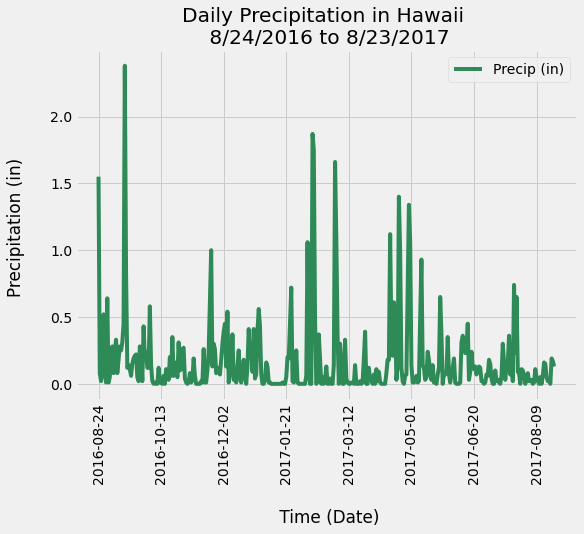

In [70]:
# Use Pandas Plotting with Matplotlib to plot the data

precip = prcp_df.plot(kind = "line", figsize = (8, 6), 
                     title = "Daily Precipitation in Hawaii \n 8/24/2016 to 8/23/2017", 
                     legend = True, color = "seagreen", rot = 90)
precip.set_xlabel("\n Time (Date)" )
precip.set_ylabel("Precipitation (in) \n")
                   

In [71]:
prcp_df.index.dtype

dtype('O')

In [72]:
## Also plotting montly averages over time (using pandas), as an alterate way to visualize this data,
#first, make copy of df 
prcp2_df = prcp_df.copy()

#convert index to datetime
prcp2_df.index = pd.to_datetime(prcp2_df.index)

#define column name for the index
prcp2_df["Date"] = prcp2_df.index
prcp2_df['Month-Year'] = pd.to_datetime(prcp2_df['Date']).dt.to_period('M')

mon_df = prcp2_df.groupby(prcp2_df["Month-Year"]).mean()
mon_df.head()


,Precip (in)
Month-Year,
2016-08,0.390000
2016-09,0.281000
2016-10,0.120323
2016-11,0.131000
2016-12,0.199677


Text(0, 0.5, 'Average Precipitation (in) \n')

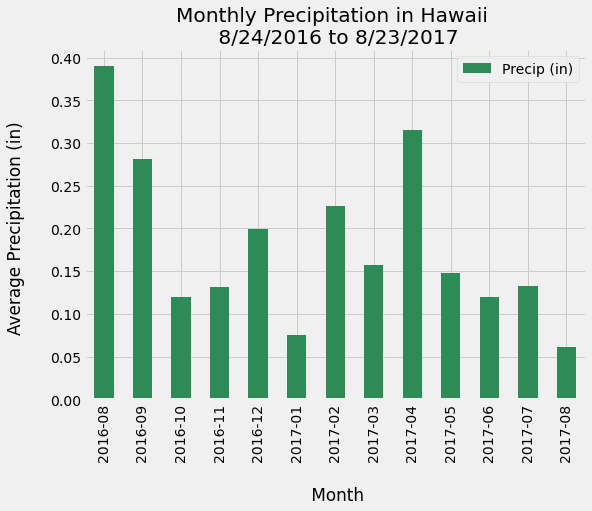

In [73]:
precip_mon = mon_df.plot(kind = "bar", figsize = (8, 6), 
                     title = "Monthly Precipitation in Hawaii \n 8/24/2016 to 8/23/2017", 
                     legend = True, color = "seagreen", rot = 90)

precip_mon.set_xlabel("\n Month" )
precip_mon.set_ylabel("Average Precipitation (in) \n")

In [74]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df[["Precip (in)"]].describe()

,Precip (in)
count,365.000000
mean,0.170164
std,0.295888
min,0.000000
25%,0.010000
50%,0.070000
75%,0.190000
max,2.380000


In [75]:
# Design a query to show how many stations are available in this dataset?
# use distinct

sta_count = session.query(station.station).group_by(station.station).count()
print(f"There are {sta_count} stations in this dataset.")

There are 9 stations in this dataset.


In [76]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [77]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# station number USC00519281 

data = [measurement.station, 
        func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)]        

temp_stats = session.query(*data).filter(measurement.station == 'USC00519281').all()
print(f"The station ID, and minimum, maximum, and average temperature (deg F), were as follows: \n \
{temp_stats}.")


The station ID, and minimum, maximum, and average temperature (deg F), were as follows: 
 [('USC00519281', 54.0, 85.0, 71.66378066378067)].


In [78]:
## Query the last 12 months of temperature observation data for this station and plot the results as a 
## histogram (bins = 12)

## First get latest measurement date at this station
latest_date2 = session.query(measurement.date).\
    filter(measurement.station == 'USC00519281').\
    order_by(measurement.date.desc()).first()
latest_date2

('2017-08-18')

In [79]:
## Get start date, one year earlier than than the latest measurement date at this station
start_date2 = dt.date(2017, 8, 18) - dt.timedelta(days=365)
start_date2 

datetime.date(2016, 8, 18)

In [80]:
## Get temperatures after start date 

tobs = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date > start_date2).all()

tobs_df = pd.DataFrame(tobs, columns = ['tobs'])
tobs_df.head()

,tobs
0,79.0
1,81.0
2,79.0
3,78.0
4,77.0


In [81]:
## Creat list for plotting 
tobs_list = tobs_df['tobs']

Text(0, 0.5, 'Frequency \n')

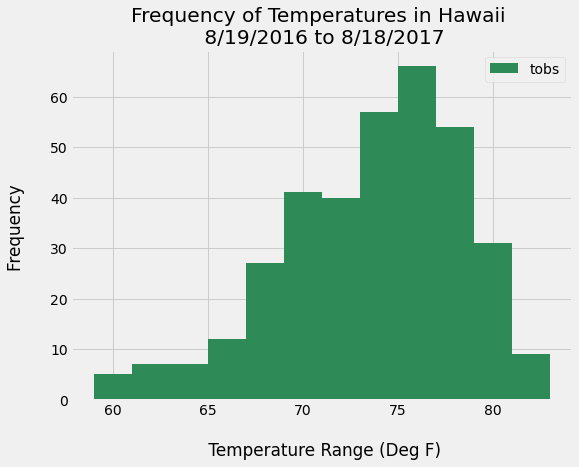

In [82]:
hist = tobs_list.plot.hist(figsize = (8, 6), bins =12,
                     title = "Frequency of Temperatures in Hawaii \n 8/19/2016 to 8/18/2017", 
                     legend = True, color = "seagreen")

hist.set_xlabel("\n Temperature Range (Deg F)" )
hist.set_ylabel("Frequency \n")

# Step 2 - Climate App
#### Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

    Use Flask to create your routes.


In [83]:
## see app.py file